# QP: Podracing

We are entered in the race of the century! Just like Anakin Skywalker, we built our own podracer and are about to begin the race. The official informs us that there are certain checkpoints that we need to hit. Our goal is to save as much fuel as possible so we don’t run out during the race.

Before we start the race, we must figure out the appropriate thruster burns at each instant.
 * We'll (approximately) model thrust as a 2D vector containing info on direction change
 * Amount of fuel we consume when we use thrusters is calculated as $L_2$ norm of thrust vector
 

In [1]:
using JuMP, HiGHS

k = 4              # number of checkpoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vectors of checkpoint locations

# times at which we must hit checkpoints
T[1] = 1
T[2] = 20
T[3] = 50
T[4] = 60

# define checkpoints' x and y coords
way_xy = [ 1   4   6   1
           1   3   0   1 ]

m = Model(HiGHS.Optimizer) 
set_silent(m)

@variable(m, x[1:2,1:T[k]])  # position at each time
@variable(m, v[1:2,1:T[k]])  # velocity at each time
@variable(m, u[1:2,1:T[k]])  # thruster input at each time

# satisfy the dynamics (with zero initial velocity)
# Note the use of '.' form of constraints, to make the constraints hold for each component of the vector 

@constraint(m, v[:,1] .== [0;0])
@constraint(m, x[:,1] .== [1;1])
# model system dynamics
for t in 1:T[k]-1
    @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
    @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
end

# hit all the checkpoints
for i in 1:k
    @constraint(m, x[:,T[i]] .== way_xy[:,i])
end

# minimize 2-norm (squared) of acceleration
@objective(m, Min, sum(u.^2))
optimize!(m)
y1 = value(sum(u.^2))
y2 = value(sum( (x[:,T]-way_xy).^2  ))
xopt = value.(x)



2×60 Matrix{Float64}:
 1.0  1.0  1.02433  1.0718   1.14121  …  2.69776   2.13908   1.57172   1.0
 1.0  1.0  1.02919  1.08448  1.16279     0.586977  0.720511  0.859014  1.0

## Plot Model Output

We can visualize our solution by plotting the output below:


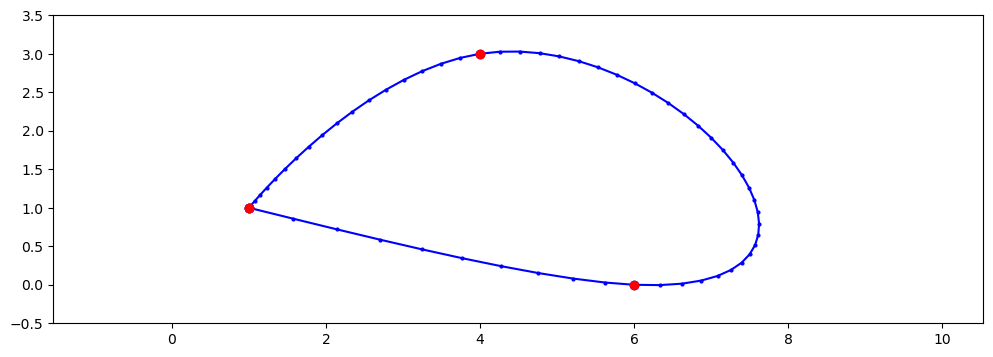

In [2]:

# plot the solution against the checkpoints
using PyPlot
figure(figsize=(12,4))
plot( xopt[1,:], xopt[2,:], "b.-", markersize=4 )
plot( xopt[1,:][T], xopt[2,:][T], "b.", markersize=12 )
plot( way_xy[1,:], way_xy[2,:], "r.", markersize=12 )
axis("equal")
axis((1.,8.,-.5,3.5));
# Only need this in vscode?
display(gcf())